# Understanding Heart Disease Using Big Data

# Importing required modules

In [17]:
import pyspark
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report, confusion_matrix

# Creating spark session

In [18]:
spark = SparkSession.builder.appName("Heart Failure Prediction").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

# Importing dataset

In [19]:
heart = spark.read.csv('/Users/revathysurendran/Documents/BigData/heart.csv',header=True, inferSchema=True)
heart.printSchema()
heart.show(5,0)
print('No: of rows in dataset: ',heart.count())
print('No: of columns in dataset: ',len(heart.columns))
numeric_features = [t[0] for t in heart.dtypes if t[1] == 'int']
print('\nNumerical features: \n',heart.select(numeric_features).describe().toPandas().transpose())
categorical_features = [t[0] for t in heart.dtypes if t[1] == 'string']
print('\nCategorical features: \n',heart.select(categorical_features).describe().toPandas().transpose())

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|40 |M  |ATA          |140      |289        |0        |Normal    |172  |N             |0.0    |Up      |0           |
|49 |F  |NAP          |160  

# Data preprocessing and splitting

In [4]:
categoricalColumns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
featureColumns = [column+'_ohe' for column in categoricalColumns]
indexer = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep') for column in categoricalColumns]
encoder = [OneHotEncoder(inputCol=column+'_index', outputCol=column+'_ohe') for column in categoricalColumns]

pipeline = Pipeline(stages = indexer+encoder)
pipelineModel = pipeline.fit(heart).transform(heart)
assembler = VectorAssembler(inputCols=featureColumns, outputCol='featuresVector')
data = assembler.transform(pipelineModel)

# Standardize the features
scaler = StandardScaler(inputCol='featuresVector', outputCol='scaled_features')
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)
data.select('scaled_features').show(5)

train_data, test_data = data.randomSplit([0.7, 0.3],seed=42)
print("Train dataset:", train_data.count())
print("Test dataset:", test_data.count())

+--------------------+
|     scaled_features|
+--------------------+
|(14,[0,4,6,9,12],...|
|(14,[1,3,6,9,11],...|
|(14,[0,4,8,9,12],...|
|(14,[1,2,6,10,11]...|
|(14,[0,3,6,9,12],...|
+--------------------+
only showing top 5 rows

Train dataset: 681
Test dataset: 237


# Data visualization

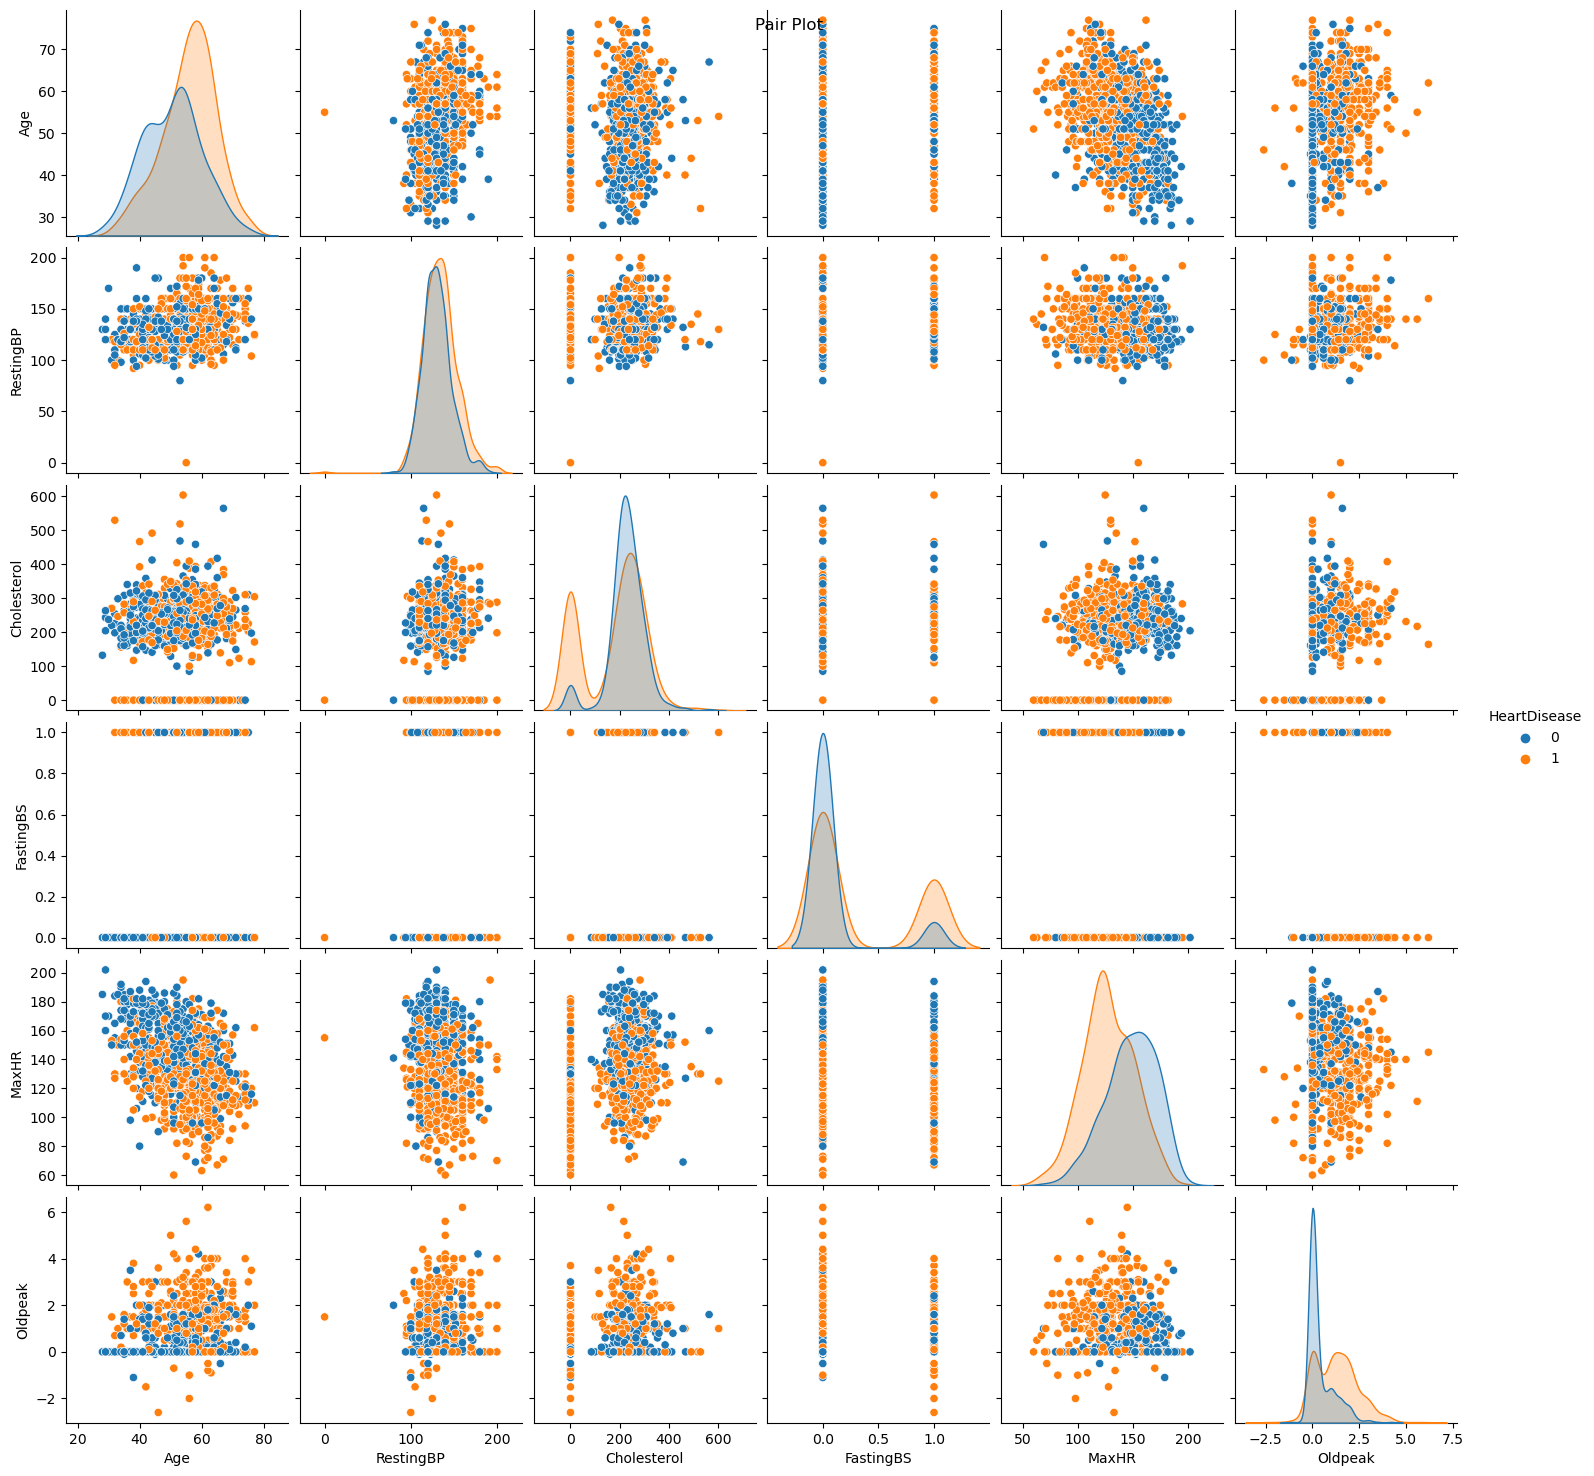

In [5]:
# Pair plot
sns.pairplot(heart.toPandas(), hue='HeartDisease')
plt.suptitle('Pair Plot')
plt.show()

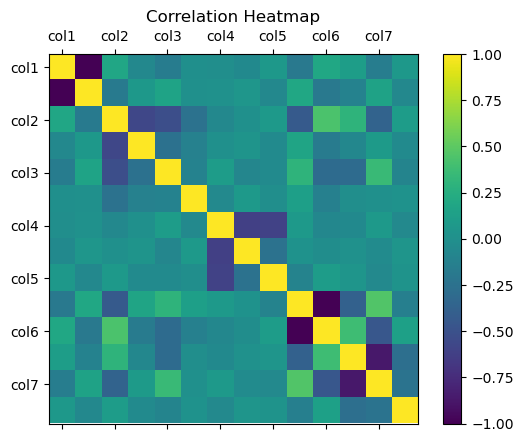

In [6]:
#Correlation Heatmap
matrix = Correlation.corr(data, "featuresVector").collect()[0][0]
corrmatrix = matrix.toArray().tolist()
columns = ['col1','col2','col3','col4','col5','col6','col7','col8','col9', 'col10','col11','col12']
df = spark.createDataFrame(corrmatrix,columns)
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Heatmap")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns, 234)

# Applying ML models

# Random Forest

Random Forest model

AUC: 0.8903162055335967
Accuracy: 0.8438818565400844
Precision: 0.8581560283687943
Recall: 0.8581560283687943
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        99
           1       0.86      0.88      0.87       138

    accuracy                           0.84       237
   macro avg       0.84      0.84      0.84       237
weighted avg       0.84      0.84      0.84       237



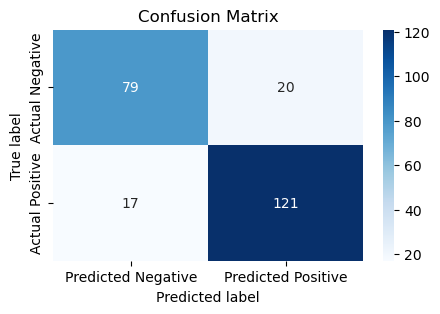

In [29]:
rfc = RandomForestClassifier(labelCol='HeartDisease',featuresCol='scaled_features')
rfc_model = rfc.fit(train_data)
rfc_pred = rfc_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='HeartDisease',metricName='areaUnderROC')
rfc_auc = evaluator.evaluate(rfc_pred)
total_count = rfc_pred.count()
correct_count = rfc_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
true_positive_count = rfc_pred.filter((col("prediction") == 1) & (col("HeartDisease") == 1)).count()
predicted_positive_count = rfc_pred.filter(col("prediction") == 1).count()
precision = true_positive_count / predicted_positive_count if predicted_positive_count != 0 else 0
actual_positive_count = rfc_pred.filter(col("prediction") == 1).count()
recall = true_positive_count / actual_positive_count if actual_positive_count != 0 else 0
predictions_train = rfc_model.transform(train_data)
y_true = rfc_pred.select(['HeartDisease']).collect()
y_pred = rfc_pred.select(['prediction']).collect()
y_true_array = np.array([row['HeartDisease'] for row in rfc_pred.select('HeartDisease').collect()])
y_pred_array = np.array([row['prediction'] for row in rfc_pred.select('prediction').collect()])
print('Random Forest model\n')
print(f'AUC: {rfc_auc}')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true_array, y_pred_array)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Gradient Boosted Tree

Gradient Boosted Tree 

AUC: 0.8802151954325866
Accuracy: 0.8354430379746836
Precision: 0.8561151079136691
Recall: 0.8561151079136691
              precision    recall  f1-score   support

           0       0.81      0.80      0.80        99
           1       0.86      0.86      0.86       138

    accuracy                           0.84       237
   macro avg       0.83      0.83      0.83       237
weighted avg       0.84      0.84      0.84       237



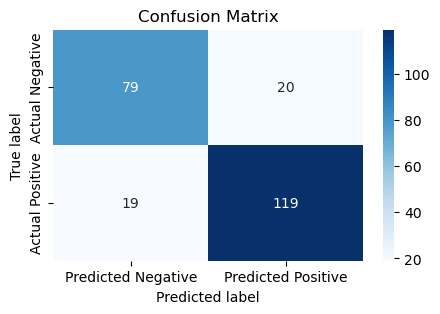

In [28]:
gbt = GBTClassifier(labelCol='HeartDisease', featuresCol='scaled_features', maxIter=10)
gbtModel = gbt.fit(train_data)
gbt_pred = gbtModel.transform(test_data)
gbt_auc = evaluator.evaluate(gbt_pred)
total_count = gbt_pred.count()
correct_count = gbt_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
true_positive_count = gbt_pred.filter((col("prediction") == 1) & (col("HeartDisease") == 1)).count()
predicted_positive_count = gbt_pred.filter(col("prediction") == 1).count()
precision = true_positive_count / predicted_positive_count if predicted_positive_count != 0 else 0
actual_positive_count = gbt_pred.filter(col("prediction") == 1).count()
recall = true_positive_count / actual_positive_count if actual_positive_count != 0 else 0
predictions_train = gbtModel.transform(train_data)
y_true = gbt_pred.select(['HeartDisease']).collect()
y_pred = gbt_pred.select(['prediction']).collect()
y_true_array = np.array([row['HeartDisease'] for row in gbt_pred.select('HeartDisease').collect()])
y_pred_array = np.array([row['prediction'] for row in gbt_pred.select('prediction').collect()])
print("Gradient Boosted Tree \n" )
print(f"AUC: {gbt_auc}" )
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true_array, y_pred_array)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression

Logistic Regression 

AUC: 0.8965012443273311
Accuracy: 0.8396624472573839
Precision: 0.8571428571428571
Recall: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.86      0.87      0.86       138

    accuracy                           0.84       237
   macro avg       0.84      0.83      0.83       237
weighted avg       0.84      0.84      0.84       237



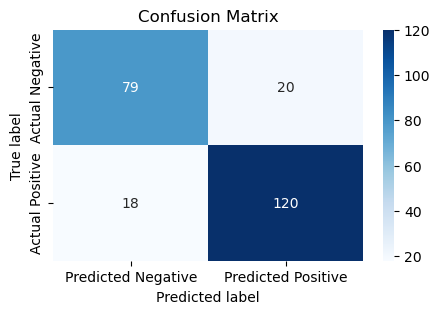

In [27]:
lr = LogisticRegression(labelCol='HeartDisease', featuresCol='scaled_features', maxIter=10)
lrModel = lr.fit(train_data)
lr_pred = lrModel.transform(test_data)
lr_auc = evaluator.evaluate(lr_pred)
total_count = lr_pred.count()
correct_count = lr_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
true_positive_count = lr_pred.filter((col("prediction") == 1) & (col("HeartDisease") == 1)).count()
predicted_positive_count = lr_pred.filter(col("prediction") == 1).count()
precision = true_positive_count / predicted_positive_count if predicted_positive_count != 0 else 0
actual_positive_count = lr_pred.filter(col("prediction") == 1).count()
recall = true_positive_count / actual_positive_count if actual_positive_count != 0 else 0
predictions_train = lrModel.transform(train_data)
y_true = lr_pred.select(['HeartDisease']).collect()
y_pred = lr_pred.select(['prediction']).collect()
y_true_array = np.array([row['HeartDisease'] for row in lr_pred.select('HeartDisease').collect()])
y_pred_array = np.array([row['prediction'] for row in lr_pred.select('prediction').collect()])
print("Logistic Regression \n" )
print(f"AUC: {lr_auc}" )
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true_array, y_pred_array)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Support Vector Classifier

Support Vector Classifier 

AUC: 0.8822280778802517
Accuracy: 0.7932489451476793
Precision: 0.8396946564885496
Recall: 0.8396946564885496
              precision    recall  f1-score   support

           0       0.74      0.79      0.76        99
           1       0.84      0.80      0.82       138

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.80      0.79      0.79       237



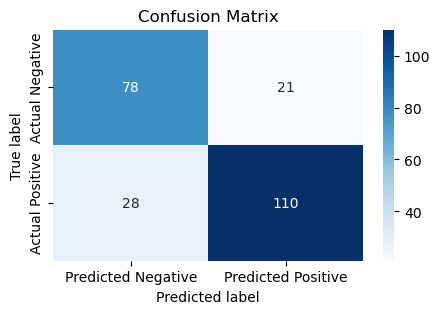

In [26]:
svc = LinearSVC(labelCol='HeartDisease', featuresCol='scaled_features')
svcModel = svc.fit(train_data)
svc_pred = svcModel.transform(test_data)
svc_auc = evaluator.evaluate(svc_pred)
total_count = svc_pred.count()
correct_count = svc_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
true_positive_count = svc_pred.filter((col("prediction") == 1) & (col("HeartDisease") == 1)).count()
predicted_positive_count = svc_pred.filter(col("prediction") == 1).count()
precision = true_positive_count / predicted_positive_count if predicted_positive_count != 0 else 0
actual_positive_count = svc_pred.filter(col("prediction") == 1).count()
recall = true_positive_count / actual_positive_count if actual_positive_count != 0 else 0
predictions_train = svcModel.transform(train_data)
y_true = svc_pred.select(['HeartDisease']).collect()
y_pred = svc_pred.select(['prediction']).collect()
y_true_array = np.array([row['HeartDisease'] for row in svc_pred.select('HeartDisease').collect()])
y_pred_array = np.array([row['prediction'] for row in svc_pred.select('prediction').collect()])
print("Support Vector Classifier \n" )
print(f"AUC: {svc_auc}" )
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true_array, y_pred_array)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Cross Validation

In [20]:
#Random Forest
rfc = RandomForestClassifier(labelCol='HeartDisease',featuresCol='scaled_features')
paramGrid = ParamGridBuilder().addGrid(rfc.numTrees, [10, 20, 30]).addGrid(rfc.maxDepth, [5, 10, 15]).build()
crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='HeartDisease', metricName='areaUnderROC'),
                          numFolds=5) 
cvModel = crossval.fit(train_data)
rfc_pred = cvModel.transform(test_data)
total_count = rfc_pred.count()
correct_count = rfc_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
print("Accuracy:", accuracy)

Accuracy: 0.8354430379746836


In [22]:
#Gradient Boosted Tree
gbt = GBTClassifier(labelCol='HeartDisease', featuresCol='scaled_features', maxIter=10)
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 10, 15]).build()
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='HeartDisease', metricName='areaUnderROC'),
                          numFolds=5)
cvModel = crossval.fit(train_data)
gbt_pred = cvModel.transform(test_data)
total_count = gbt_pred.count()
correct_count = gbt_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
print("Accuracy:", accuracy)

Accuracy: 0.8354430379746836


In [23]:
#Logistic Regression
lr = LogisticRegression(labelCol='HeartDisease', featuresCol='scaled_features', maxIter=10)
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01, 0.001]).build()
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='HeartDisease', metricName='areaUnderROC'),
                          numFolds=5)
cvModel = crossval.fit(train_data)
lr_pred = cvModel.transform(test_data)
total_count = lr_pred.count()
correct_count = lr_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
print("Accuracy:", accuracy)

Accuracy: 0.8396624472573839


In [24]:
#Support vector classifier
svc = LinearSVC(labelCol='HeartDisease', featuresCol='scaled_features')
paramGrid = ParamGridBuilder().addGrid(svc.maxIter, [10, 20, 30]).addGrid(svc.regParam, [0.1, 0.01, 0.001]).build()
crossval = CrossValidator(estimator=svc,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='HeartDisease', metricName='areaUnderROC'),
                          numFolds=5)
cvModel = crossval.fit(train_data)
svc_pred = cvModel.transform(test_data)
total_count = svc_pred.count()
correct_count = svc_pred.filter(col("prediction") == col("HeartDisease")).count()
accuracy = correct_count / total_count
print("Accuracy:", accuracy)

Accuracy: 0.7932489451476793


In [ ]:
spark.stop()